In [119]:
import pandas as pd
import numpy as np
import bootstrapped.bootstrap as boot
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
from sklearn.utils import resample
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn import metrics as met
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE 

# 1.
# c)
(i) Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc)

Correlation structure, distribution, entropy, stationarity and scaling properties, Means in each of the features, Standard deviations of each of the features, skewness, kurtosis and higher order moments of the each feature, Maximum and Minimum values

In [2]:
columns = ["time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
df = pd.read_csv('../data/AReM/bending1/dataset1.csv', skiprows=[0, 1, 2, 3, 4], names=columns)
df

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,39.25,0.43,22.75,0.43,33.75,1.3
1,250,39.25,0.43,23.00,0.00,33.00,0.0
2,500,39.25,0.43,23.25,0.43,33.00,0.0
3,750,39.50,0.50,23.00,0.71,33.00,0.0
4,1000,39.50,0.50,24.00,0.00,33.00,0.0
...,...,...,...,...,...,...,...
475,118750,43.33,0.47,25.00,0.00,30.00,0.0
476,119000,43.50,0.50,25.50,0.50,30.00,0.0
477,119250,43.50,0.50,24.75,0.43,30.00,0.0
478,119500,43.50,0.50,24.33,0.47,30.00,0.0


In [3]:
positions = ['bending1', 'bending2','cycling', 'lying', 'sitting', 'standing', 'walking']

In [8]:
count = 1
test_matrix = {} # map from position name to list of testing dataframes
train_matrix = {} # map from position name to list of training dataframes
full_matrix = {} # map from position name to list of all dataframes for datasets in that position
# feel like i could just get the first two from slicing the full one

bend1_dfs_test = []
bend1_dfs_train = []
full_dfs = []
for i in range(1, 8):
    count += 1
    if i < 3:
        test_new_df = pd.read_csv(f'../data/AReM/bending1/dataset{i}.csv', skiprows=[0, 1, 2, 3, 4], names=columns)
        bend1_dfs_test.append(test_new_df)
        full_dfs.append(test_new_df)
        
    else:
        train_new_df = pd.read_csv(f'../data/AReM/bending1/dataset{i}.csv', skiprows=[0, 1, 2, 3, 4], names=columns)
        bend1_dfs_train.append(train_new_df)
        full_dfs.append(train_new_df)

test_matrix['bending'] = bend1_dfs_test
train_matrix['bending'] = bend1_dfs_train
full_matrix['bending'] = full_dfs


bend2_dfs_test = []
bend2_dfs_train = []
full_dfs = []
for i in range(1, 7):
    count += 1
    if i < 3:
        test_new_df = pd.read_csv(f'../data/AReM/bending2/dataset{i}.csv', skiprows=[0, 1, 2, 3, 4], names=columns)
        bend2_dfs_test.append(test_new_df)
        full_dfs.append(test_new_df)

    else:
        train_new_df = pd.read_csv(f'../data/AReM/bending2/dataset{i}.csv', skiprows=[0, 1, 2, 3, 4], names=columns)
        bend2_dfs_train.append(train_new_df)
        full_dfs.append(train_new_df)


test_matrix['bending'].extend(bend2_dfs_test)
train_matrix['bending'].extend(bend2_dfs_train)
full_matrix['bending'].extend(full_dfs)


for i in range(2, len(positions)):
    df_list = []
    df_list_train = []
    df_list_test = []
    full_dfs = []
    for j in range(1, 16):
        count += 1
        if j < 4:
            new_df = pd.read_csv(f'../data/AReM/{positions[i]}/dataset{j}.csv', skiprows=[0, 1, 2, 3, 4], names=columns)
            df_list_test.append(new_df)
            full_dfs.append(new_df)
        else:
            new_df = pd.read_csv(f'../data/AReM/{positions[i]}/dataset{j}.csv', skiprows=[0, 1, 2, 3, 4], names=columns)
            df_list_train.append(new_df)
            full_dfs.append(new_df)
    test_matrix[positions[i]] = df_list_test
    train_matrix[positions[i]] = df_list_train
    full_matrix[positions[i]] = full_dfs

full_matrix

{'bending': [       time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
  0         0      39.25       0.43      22.75       0.43      33.75        1.3
  1       250      39.25       0.43      23.00       0.00      33.00        0.0
  2       500      39.25       0.43      23.25       0.43      33.00        0.0
  3       750      39.50       0.50      23.00       0.71      33.00        0.0
  4      1000      39.50       0.50      24.00       0.00      33.00        0.0
  ..      ...        ...        ...        ...        ...        ...        ...
  475  118750      43.33       0.47      25.00       0.00      30.00        0.0
  476  119000      43.50       0.50      25.50       0.50      30.00        0.0
  477  119250      43.50       0.50      24.75       0.43      30.00        0.0
  478  119500      43.50       0.50      24.33       0.47      30.00        0.0
  479  119750      43.50       0.50      24.25       0.43      30.00        0.0
  
  [480 rows x 7 columns],


In [9]:
# create list of column headers
def get_sub(x): # taken from https://www.geeksforgeeks.org/how-to-print-superscript-and-subscript-in-python/
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    sub_s = "ₐ₈CDₑբGₕᵢⱼₖₗₘₙₒₚQᵣₛₜᵤᵥwₓᵧZₐ♭꜀ᑯₑբ₉ₕᵢⱼₖₗₘₙₒₚ૧ᵣₛₜᵤᵥwₓᵧ₂₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎"
    res = x.maketrans(''.join(normal), ''.join(sub_s))
    return x.translate(res)

metrics = ['min', 'max', 'mean', 'median', 'σ', 'Q1', 'Q3']
headers = []
for i in range(1, 7):
    for metric in metrics:
        headers.append(f'{metric}{get_sub(str(i))}')


In [10]:
# calculate minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 
# 6 time series in each instance
def get_series_features(matrix, headers):
#     columns = ["avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
    if 'time' in matrix['bending'][0].columns:
        columns = list(matrix['bending'][0].drop('time', axis=1).columns)
    else:
        columns = list(matrix['bending'][0].columns)
    new_feature_df = pd.DataFrame(columns=headers)
    count1 = 1
    for key, value in matrix.items():
        for dataframe in value:
            numbers = []
            for col in columns:
                time_features = dataframe[col].describe()
                mean = time_features[1]
                std_dev = time_features[2]
                minimum = time_features[3]
                q1 = time_features[4]
                median = time_features[5]
                q3 = time_features[6]
                maximum = time_features[7]
                numbers.extend([minimum, maximum, mean, median, std_dev, q1, q3])
            new_feature_df.loc[count1] = numbers
            count1 += 1
    return new_feature_df

# list(full_matrix['bending'][0].columns)

In [11]:
time_feature_df = get_series_features(full_matrix, headers)
time_feature_df

,min₁,max₁,mean₁,median₁,σ₁,Q1₁,Q3₁,min₂,max₂,mean₂,...,σ₅,Q1₅,Q3₅,min₆,max₆,mean₆,median₆,σ₆,Q1₆,Q3₆
1,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,2.188449,33.0000,36.00,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000
2,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,0.372438,...,1.995255,32.0000,34.50,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000
3,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,1.999604,35.3625,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400
4,33.00,47.75,42.179813,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,3.849448,30.4575,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000
5,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,2.411026,28.4575,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,3.283983,13.7300,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225
85,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,3.119856,13.5000,17.75,0.00,9.67,3.432562,3.20,1.732727,2.1575,4.5650
86,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,2.823124,14.0000,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350
87,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,4.380583,...,3.131076,13.7500,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000


### iii.

In [12]:
std_dev_df = pd.DataFrame(columns=headers)
std_devs = []
boot_devs = []
for header in headers:
    std_dev = time_feature_df[header].std()
    boot_dev = boot.bootstrap(time_feature_df[header].to_numpy(), stat_func=bs_stats.std)
    boot_devs.append(f'[{boot_dev.lower_bound}, {boot_dev.upper_bound}]')
    std_devs.append(std_dev)
    
std_dev_df.loc['Confidence Interval'] = boot_devs
std_dev_df.loc['σ'] = std_devs
std_dev_df.transpose()

,Confidence Interval,σ
min₁,"[8.079506581011701, 11.053727364722157]",9.569975
max₁,"[3.2820850161493382, 5.592968294529982]",4.394362
mean₁,"[4.661419363412543, 6.049688171434825]",5.335703
median₁,"[4.745661208646035, 6.156678413707704]",5.440054
σ₁,"[1.5521175753528398, 1.9963407278323295]",1.772155
Q1₁,"[5.517903172815014, 6.822814590100251]",6.15359
Q3₁,"[4.258693040028822, 6.0412205787862785]",5.138925
min₂,"[0.0, 0.0]",0.0
max₂,"[4.625444143313781, 5.549902726699943]",5.062729
mean₂,"[1.412232702921487, 1.7795694928474943]",1.57417


### iv.
- Since we have not established any significant skewness in any of the distributions, **mean** will be a good metric for the central tendency
- Although the range could be useful to understand where the entire dataset lies, it is highly susceptible to outliers. Therefore, I think **Q1 and Q2** are more important measurements, as they tell us where the middle 50% of the distribution lies. I would put standard deviation as more important than the IQR, but then the third feature I choose would be useless (XOR q1, q2, median)

# 4
## (a)
### i. 
Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).4

In [13]:
# aggregate features from all dataframes
def get_relevant_series(matrix, current_headers):
#     columns = ["avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
    columns = matrix['bending'][0].columns
    feature_df = get_series_features(matrix, current_headers)
    feature_df # rows 1-9 are bending
               # rows 10-21 are cycling
               # rows 22-33 are lying
               # rows 34-45 are sitting
               # rows 46-57 are standing
               # rows 58-69 are walking
                
    # we only care about mean, Q1, Q3
    # we also only care about the 1st, 2nd, and 6th time series
    if feature_df.shape[1] == 6*7:
        for header in headers:
            if 'mean' not in header and 'Q1' not in header and 'Q3' not in header:
                del feature_df[header]
            elif '₁' not in header and '₂' not in header and '₆' not in header:
                del feature_df[header]
    else:
        for i, col in enumerate(feature_df):
            if 'mean' not in col and 'Q1' not in col and 'Q3' not in col or '₁₀' in col or '₁₁' in col:
                del feature_df[col]
            elif all([subscript not in col for subscript in ['₁', '₂', '₆','₇', '₈', '₁₂']]):
                del feature_df[col]

                
    # need to add column to distinguish activity for each row
    activities = []
    for i in range(1, len(feature_df) + 1):
        if 1 <= i <= 9:
            activities.append('bending')
        else:
            activities.append('not bending')
    feature_df['activity'] = activities
    return feature_df

# some utility functions
def make_feature_headers(features, num_sets):
    feature_headers = []
    for num in range(1, num_sets+1):
        for feature in features:
            feature_headers.append(f'{feature}{get_sub(str(num))}')
    return feature_headers

def join_dataframes(df1, df2):
    for i, col in enumerate(df2):
        df1[col] = df2[col]
    return df1.copy()


In [14]:
train_time_feature_df = get_relevant_series(train_matrix, make_feature_headers(metrics, 6))
train_time_feature_df

,mean₁,Q1₁,Q3₁,mean₂,Q1₂,Q3₂,mean₆,Q1₆,Q3₆,activity
1,43.954500,43.00,45.0000,0.426250,0.00,0.5000,0.493292,0.0000,0.9400,bending
2,42.179813,39.15,45.0000,0.696042,0.00,1.1200,0.613521,0.0000,1.0000,bending
3,41.678063,41.33,42.7500,0.535979,0.43,0.7100,0.383292,0.0000,0.5000,bending
4,43.454958,42.50,45.0000,0.378083,0.00,0.5000,0.679646,0.4300,0.8700,bending
5,43.969125,43.31,44.6700,0.413125,0.43,0.5000,0.555313,0.0000,0.8300,bending
...,...,...,...,...,...,...,...,...,...,...
65,33.586875,30.25,37.0000,4.576562,2.87,6.1050,3.259729,2.0500,4.3225,not bending
66,34.322750,31.00,38.0000,4.456333,2.49,5.9700,3.432562,2.1575,4.5650,not bending
67,34.546229,31.25,37.8125,4.371958,2.49,5.8000,3.338125,2.1600,4.3350,not bending
68,34.873229,31.75,38.2500,4.380583,2.50,5.9325,3.424646,2.1700,4.5000,not bending


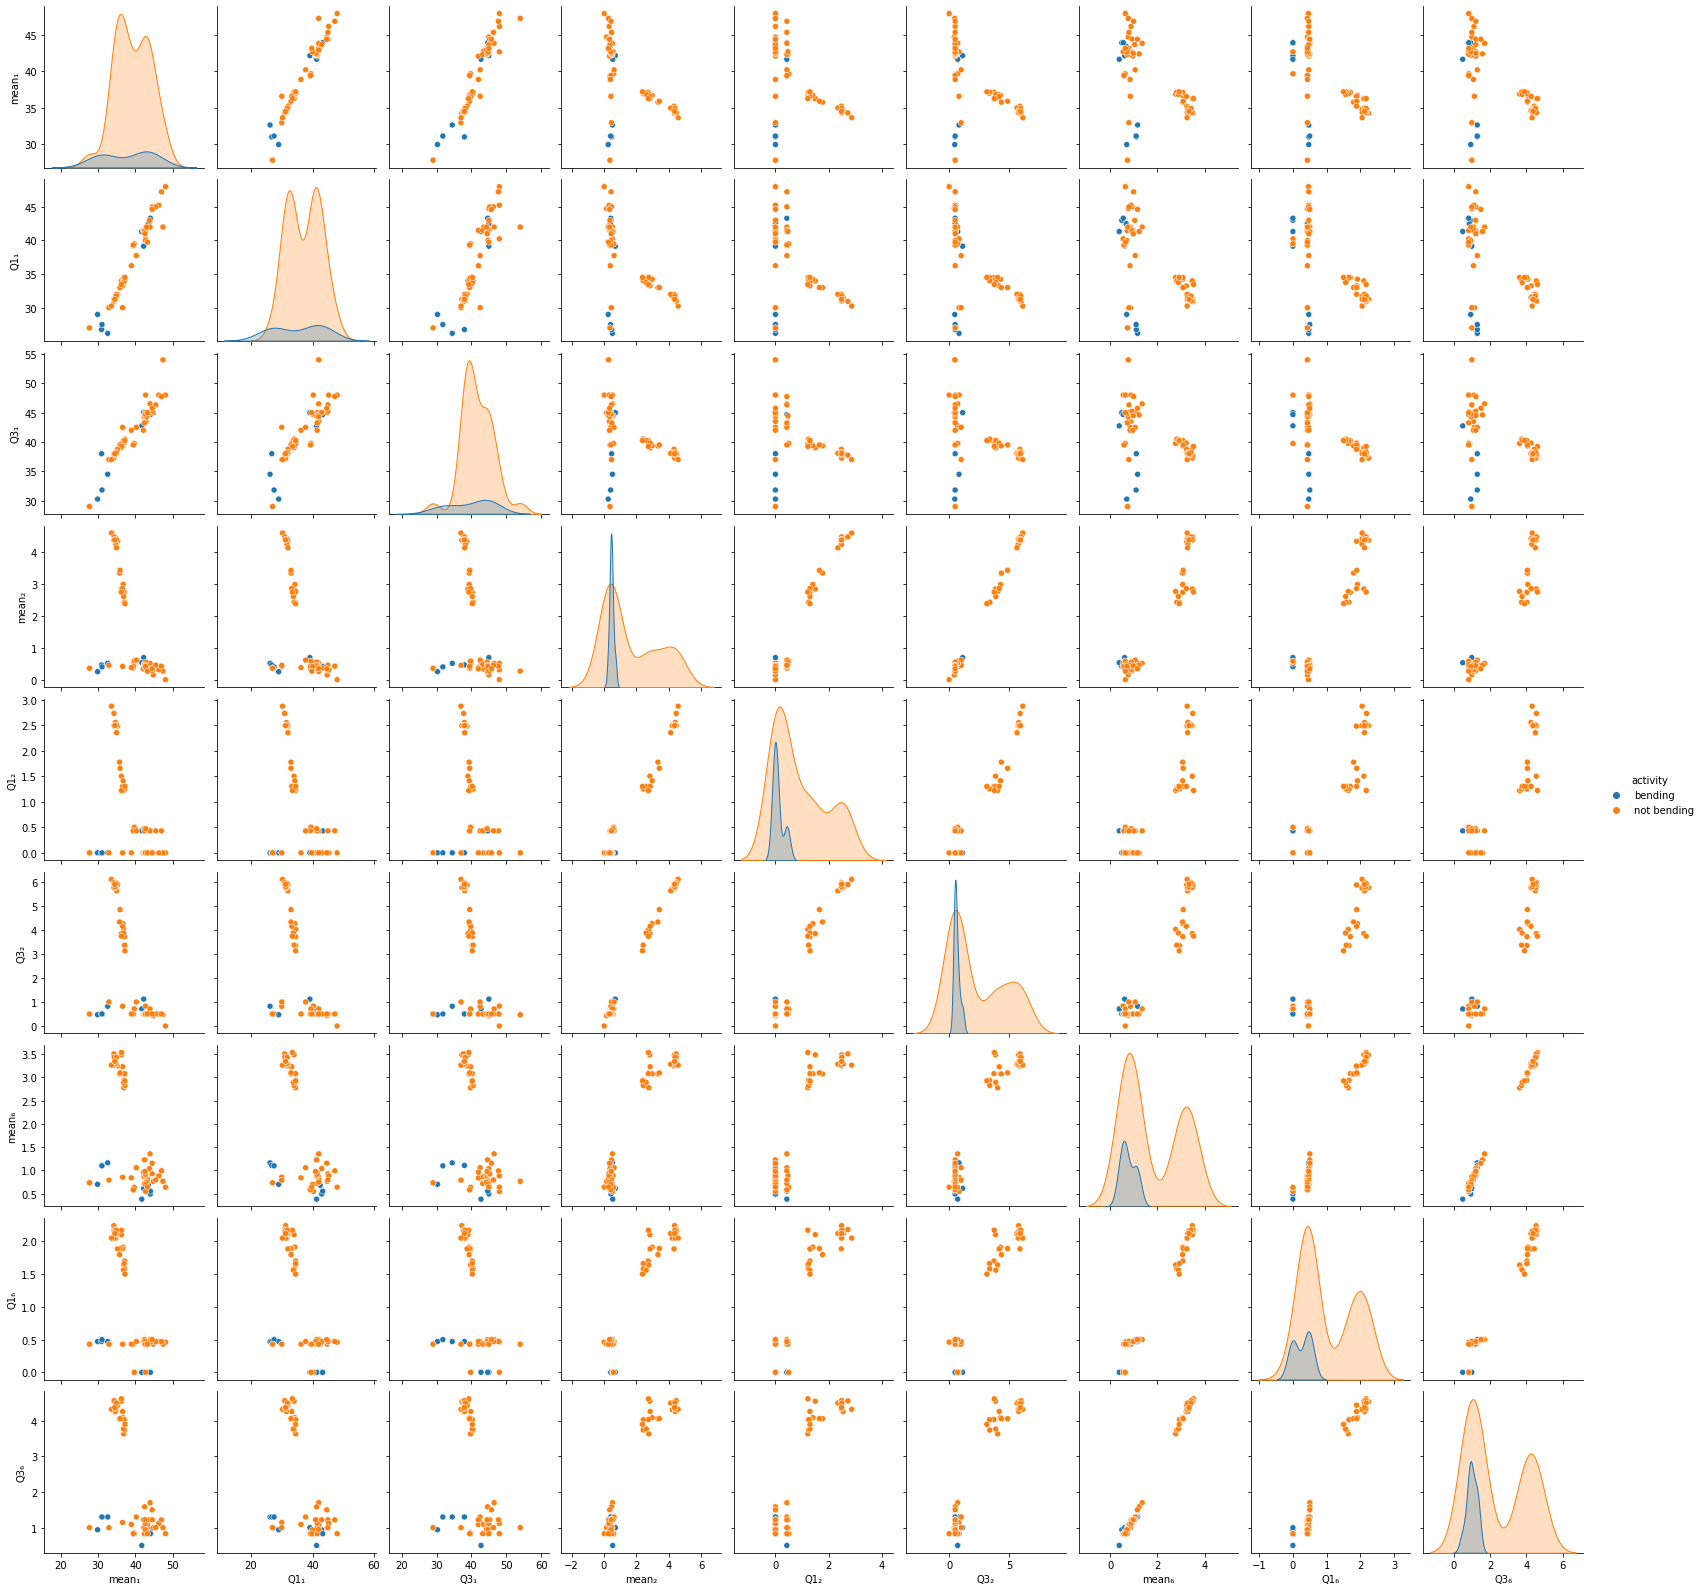

In [15]:
x_data = list(range(1, 70))
matplotlib.rc('figure', figsize=(15, 10))
sns.pairplot(train_time_feature_df, hue='activity')
plt.show()

### ii.

In [20]:
# split up time series into two parts (12 series/instance now)
# join them into one df
split_train_set = {}
current_headers = make_feature_headers(["avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"], 2)
for key, value in train_matrix.items(): # loop through all activities
    split_train_set[key] = []
    for dataframe in value:             # loop through all instances for given activity
        half_header_len = len(current_headers)//2
        new_index_df = dataframe.set_index('time')
        left_df = new_index_df[:240].set_axis(current_headers[:half_header_len], axis=1)
        right_df = new_index_df[:240].set_axis(current_headers[half_header_len:], axis=1)
        whole_df = join_dataframes(left_df, right_df)
        split_train_set[key].append(whole_df)
        # need to concatenate 2nd one to first one
split_train_set['bending'][0]

,avg_rss12₁,var_rss12₁,avg_rss13₁,var_rss13₁,avg_rss23₁,var_rss23₁,avg_rss12₂,var_rss12₂,avg_rss13₂,var_rss13₂,avg_rss23₂,var_rss23₂
time,,,,,,,,,,,,
0,42.00,0.71,21.25,0.43,30.00,0.00,42.00,0.71,21.25,0.43,30.00,0.00
250,41.50,0.50,20.25,1.48,31.25,1.09,41.50,0.50,20.25,1.48,31.25,1.09
500,41.50,0.50,14.25,1.92,33.00,0.00,41.50,0.50,14.25,1.92,33.00,0.00
750,40.75,0.83,15.75,0.43,33.00,0.00,40.75,0.83,15.75,0.43,33.00,0.00
1000,40.00,0.71,20.00,2.74,32.75,0.43,40.00,0.71,20.00,2.74,32.75,0.43
...,...,...,...,...,...,...,...,...,...,...,...,...
58750,45.50,0.50,24.00,0.00,36.00,0.00,45.50,0.50,24.00,0.00,36.00,0.00
59000,45.25,0.43,23.25,0.83,36.00,0.00,45.25,0.43,23.25,0.83,36.00,0.00
59250,45.00,0.00,20.75,1.09,36.00,0.00,45.00,0.00,20.75,1.09,36.00,0.00


In [17]:
# repeat 4(a)i. 
# aggregate relevant data for each half of the time-series
# we want to keep feature columns with subscript 1, 2, 6 and 7, 8, 12 
metrics = ['min', 'max', 'mean', 'median', 'σ', 'Q1', 'Q3']
split_train_time_features = get_relevant_series(split_train_set, make_feature_headers(metrics, 12))
split_train_time_features

,mean₁,Q1₁,Q3₁,mean₂,Q1₂,Q3₂,mean₆,Q1₆,Q3₆,mean₇,Q1₇,Q3₇,mean₈,Q1₈,Q3₈,mean₁₂,Q1₁₂,Q3₁₂,activity
1,44.057167,43.2500,45.0000,0.381042,0.0000,0.5000,0.598250,0.00,1.0000,44.057167,43.2500,45.0000,0.381042,0.0000,0.5000,0.598250,0.00,1.0000,bending
2,43.278875,42.0000,45.2500,0.673292,0.0000,1.0000,0.640958,0.00,1.2200,43.278875,42.0000,45.2500,0.673292,0.0000,1.0000,0.640958,0.00,1.2200,bending
3,41.621208,39.6525,44.2500,0.623083,0.4300,0.8300,0.419083,0.00,0.7100,41.621208,39.6525,44.2500,0.623083,0.4300,0.8300,0.419083,0.00,0.7100,bending
4,44.117042,43.5000,45.0000,0.250042,0.0000,0.5000,0.815417,0.43,1.1200,44.117042,43.5000,45.0000,0.250042,0.0000,0.5000,0.815417,0.43,1.1200,bending
5,43.486208,42.3300,44.5000,0.378667,0.0000,0.5000,0.524875,0.00,0.8300,43.486208,42.3300,44.5000,0.378667,0.0000,0.5000,0.524875,0.00,0.8300,bending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,33.334500,29.9375,36.8125,4.408083,2.8675,5.8700,3.229167,2.06,4.2450,33.334500,29.9375,36.8125,4.408083,2.8675,5.8700,3.229167,2.06,4.2450,not bending
66,34.036750,30.7500,37.7500,4.778292,2.8600,6.5050,3.543708,2.28,4.7900,34.036750,30.7500,37.7500,4.778292,2.8600,6.5050,3.543708,2.28,4.7900,not bending
67,34.033875,30.9375,37.5000,4.574625,2.7500,6.0300,3.244042,2.15,4.1500,34.033875,30.9375,37.5000,4.574625,2.7500,6.0300,3.244042,2.15,4.1500,not bending
68,34.920792,32.2500,37.8125,4.177958,2.4900,5.4550,3.430625,2.16,4.5850,34.920792,32.2500,37.8125,4.177958,2.4900,5.4550,3.430625,2.16,4.5850,not bending


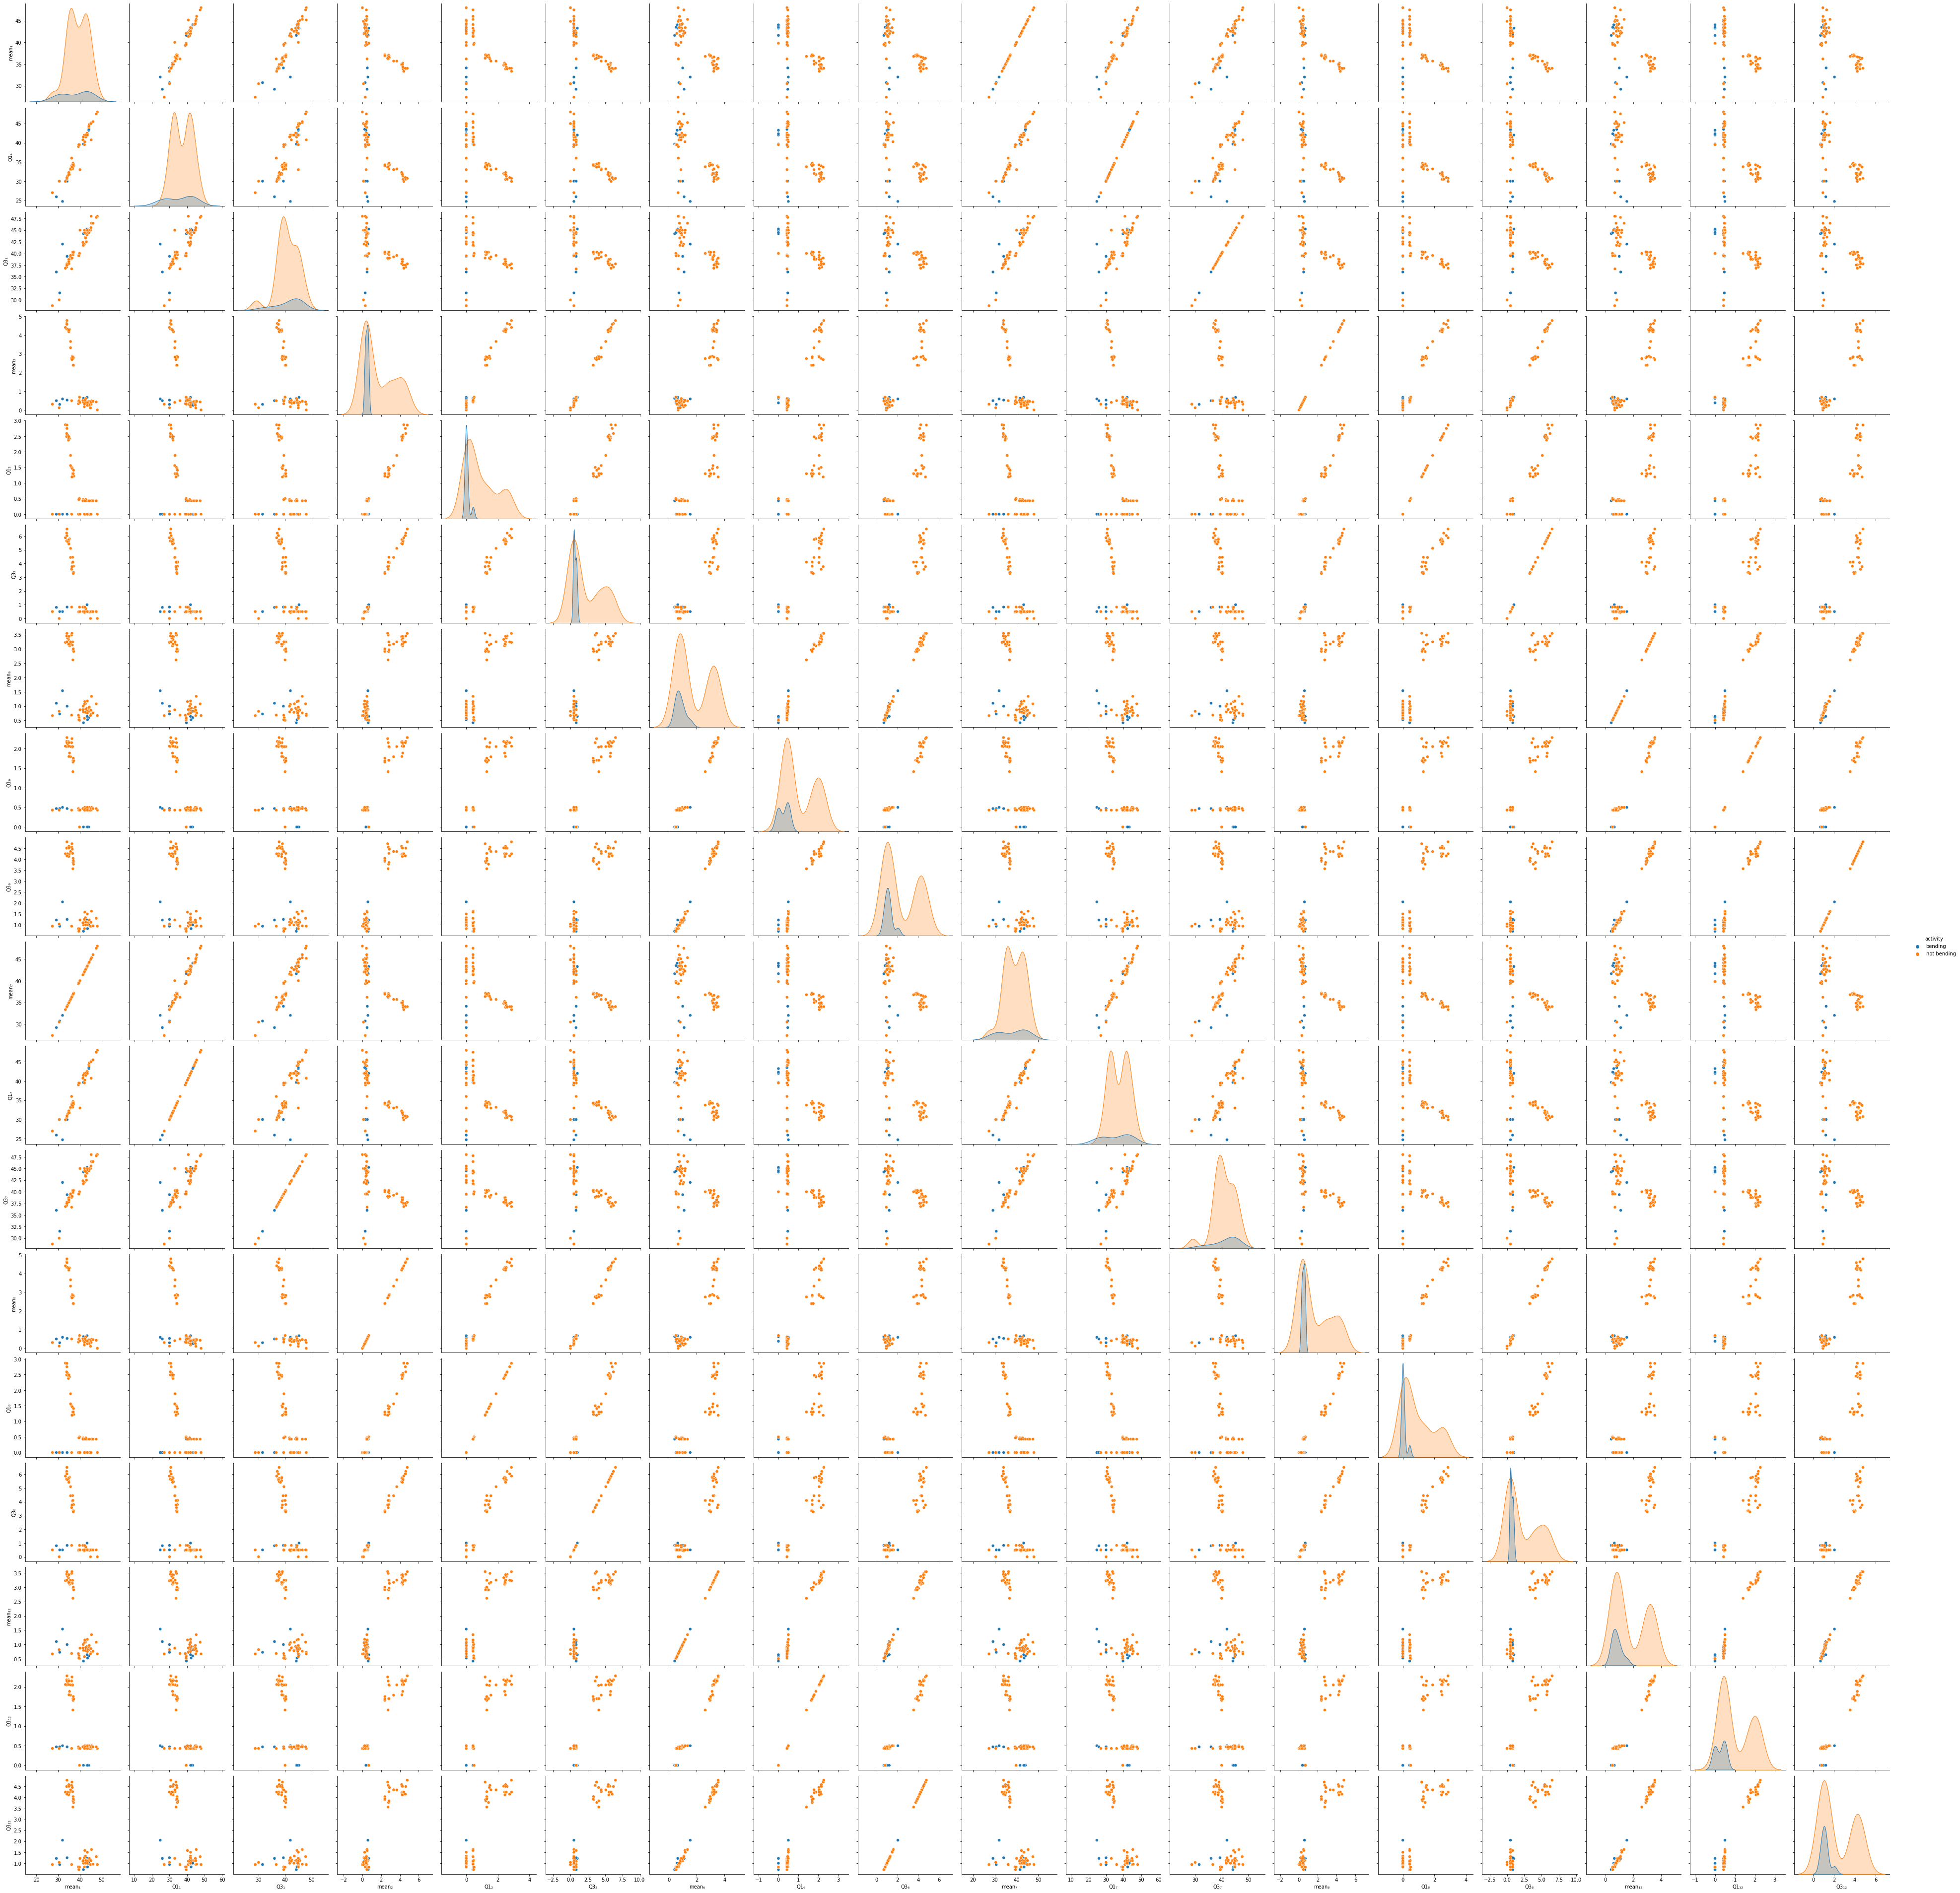

In [15]:
sns.pairplot(split_train_time_features, hue='activity', height=3)
plt.show()

- using more features in the pairplots appears to reveal some relationships that are almost perfectly linear that we're not apparent in the initial pair plot (this could just be because the graphs are smaller so lines look straighter though). However, many no-correlation-relationships (vertical/horizontal lines) still remain in the set of plots

In [21]:
# get the mean, q1, q3 for each column of dataframe
def get_features_from_df(dframe):
    numbers = []
    for i, col in enumerate(dframe):
        time_features = dframe[col].describe()
        mean = time_features[1]
        q1 = time_features[4]
        q3 = time_features[6]
        numbers.extend([mean, q1, q3])

    return numbers


# break dataset into 1-20 pieces
# then capture the time series features from them
column_names = headers.copy()
column_names.append("activity")
all_metrics = ['mean','Q1', 'Q3']
feature_dfs = []
for l in range(1, 21):                      # loop through every split size
    fold_to_feature_df = {}
    current_headers = make_feature_headers(all_metrics, l*6)
    current_headers.append('activity')
    current_feature_df = pd.DataFrame(columns=current_headers)
    row_num = 1
    len_split = 480/l
    for key, value in train_matrix.items(): # loop through every activity
        for dataframe in value:             # loop through every instance for this activity
            row = []
            for j in range(l):              # loop through instance to get every split's features
                start, end = int(j*len_split), int((1+j)*len_split)
                stats = get_features_from_df(dataframe[start:end].drop(['time'], axis=1))
#                 print(f"len(stats): {len(stats)}; i: {l}; j: {j}")
                row.extend(stats)              
            row.append("bending" if key == "bending" else "not bending")
#             print(f'len(row) : {len(row)}; len(current_headers: {len(current_headers)})')
            current_feature_df.loc[row_num] = row
            row_num += 1
    feature_dfs.append(current_feature_df)
   

In [27]:
# perform rfecv on the different feature dataframes
score_to_l_and_p = {}
for i, df in enumerate(feature_dfs):
    X, y = df.drop('activity', axis=1), df['activity']
    estimator = LogisticRegression(random_state=69, max_iter=1000, n_jobs=-1).fit(X, y)
    selector = RFECV(estimator, step=1, cv=5, scoring='accuracy', n_jobs=-1)
    selector = selector.fit(X, y.values.ravel())
    best_p = selector.n_features_
    best_p_score = np.argmax(selector.cv_results_['mean_test_score'])
    score_to_l_and_p[best_p_score] = (i+1, best_p)

max_score = max(score_to_l_and_p)
print(f'Best (l, p) pair: ({score_to_l_and_p[max_score][0]}, {score_to_l_and_p[max_score][1]})')

Best (l, p) pair: (13, 28)


### iv. 
Report the confusion matrix and show the ROC and AUC for classifier on train data

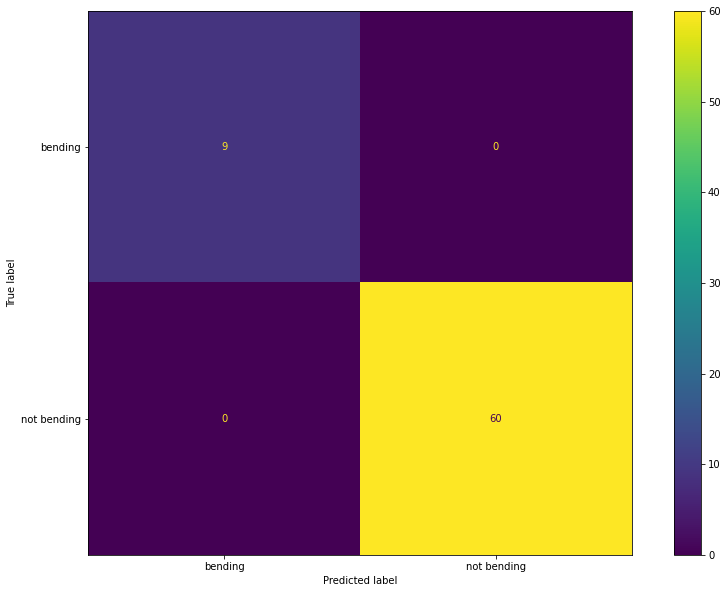

In [83]:
# show the confusion matrix for your logistic regression
X = feature_dfs[score_to_l_and_p[max_score][0]-1].drop('activity', axis=1)
y = feature_dfs[score_to_l_and_p[max_score][0]-1]['activity']
clf = LogisticRegression(random_state=69, max_iter=1000).fit(X, y)

predictions = clf.predict(X)
cm = confusion_matrix(y, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

In [55]:
f1 = sum(results['test_f1_macro'])/len(results['test_f1_macro'])
accuracy = sum(results['test_accuracy'])/len(results['test_accuracy'])
recall = sum(results['test_recall_macro'])/len(results['test_recall_macro'])
precision = sum(results['test_precision_micro'])/len(results['test_precision_micro'])
print(f'f1 score:  {f1}\naccuracy:  {accuracy}\nrecall:    {recall}\nprecision: {precision}')

f1 score:  0.7299743589743589
accuracy:  0.9274725274725275
recall:    0.7416666666666666
precision: 0.9274725274725275


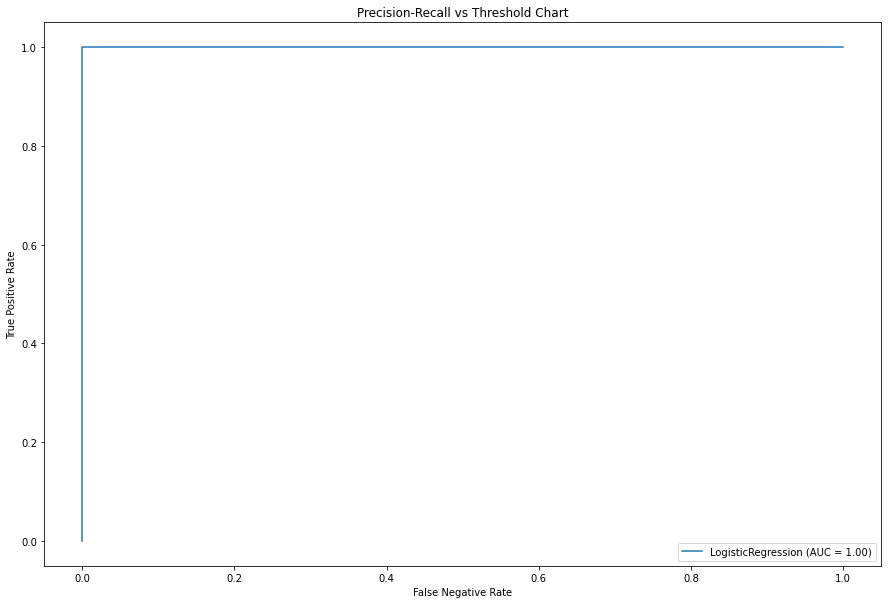

In [87]:
### Predict test_y values and probabilities based on fitted logistic 
RocCurveDisplay.from_estimator(clf, X, y)
plt.title("Precision-Recall vs Threshold Chart")
plt.ylabel("True Positive Rate")
plt.xlabel("False Negative Rate")
plt.show()

In [111]:
test_feature_dfs = []
L = 13
len_split = 480/L
test_headers = make_feature_headers(all_metrics, L*6)
test_headers.append('activity')
test_feature_df = pd.DataFrame(columns=test_headers)
row_num = 1
test_df = pd.DataFrame()
for key, value in test_matrix.items(): # loop through every activity
    for dataframe in value:             # loop through every instance for this activity
        row = []
        for j in range(L):              # loop through instance to get every split's features
            start, end = int(j*len_split), int((1+j)*len_split)
            stats = get_features_from_df(dataframe[start:end].drop(['time'], axis=1))
            row.extend(stats)              
        row.append("bending" if key == "bending" else "not bending")
        test_feature_df.loc[row_num] = row
        row_num += 1

X_test = test_feature_df.drop('activity', axis=1)
y_test = test_feature_df['activity']

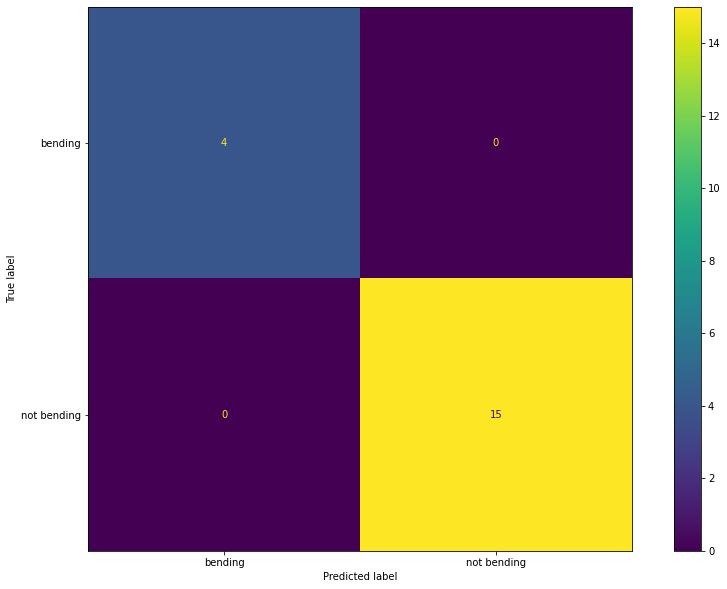

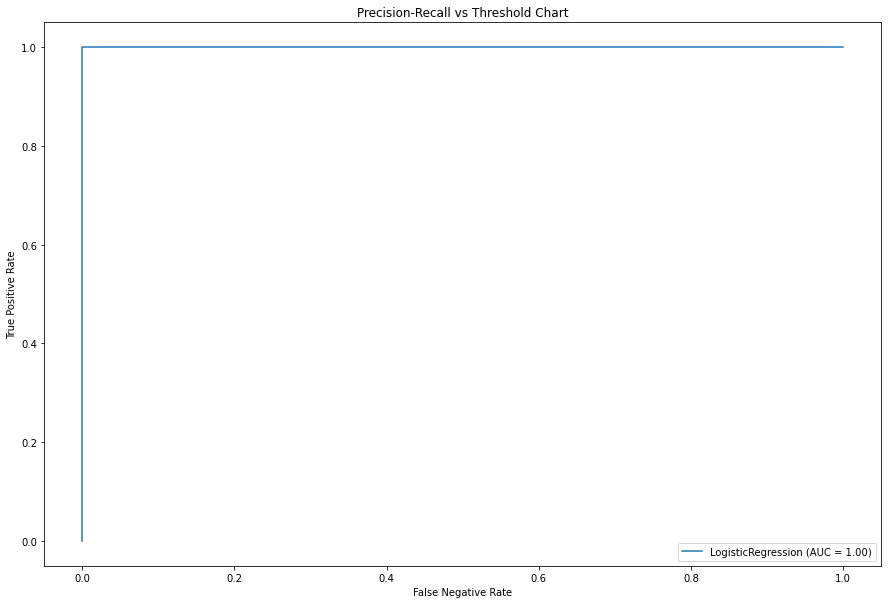

In [113]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("Precision-Recall vs Threshold Chart")
plt.ylabel("True Positive Rate")
plt.xlabel("False Negative Rate")
plt.show()

### vii.
Retrain classifier on balanced data and then report test results

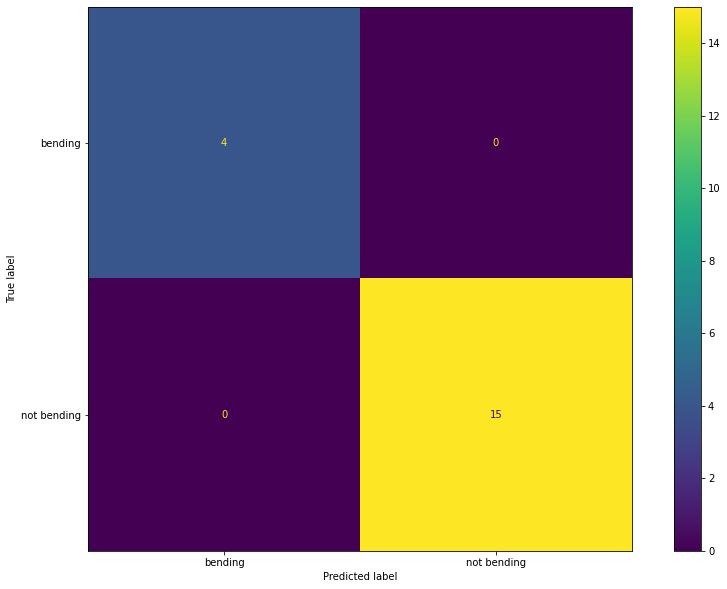

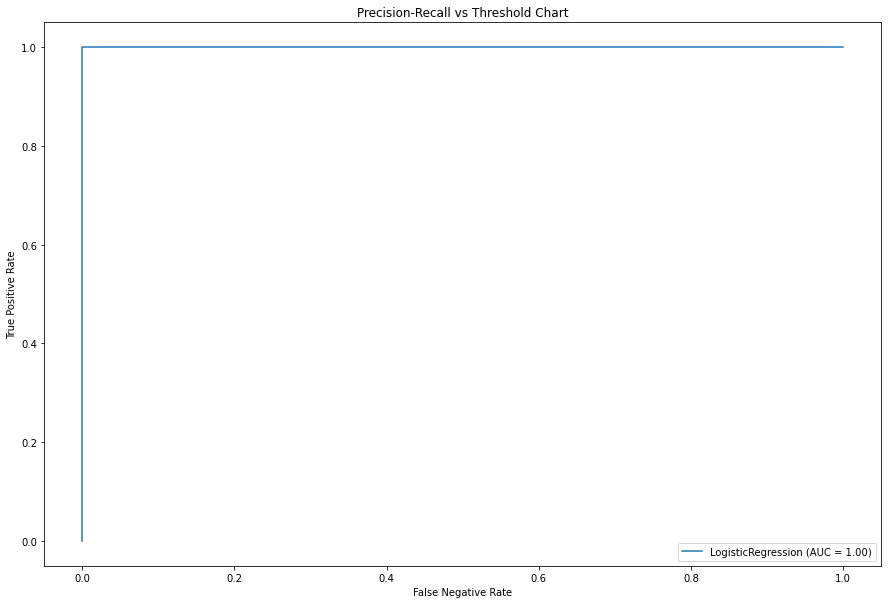

In [120]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

smote_clf = LogisticRegression(random_state=69, max_iter=1000).fit(X_res, y_res)

predictions = smote_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

RocCurveDisplay.from_estimator(smote_clf, X_test, y_test)
plt.title("Precision-Recall vs Threshold Chart")
plt.ylabel("True Positive Rate")
plt.xlabel("False Negative Rate")
plt.show()

## C
### i
Find the best l in the same way as you found it in 4(b)i to build an L1- penalized multinomial regression model to classify all activities in your train- ing set.10 Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [121]:
# break dataset into 1-20 pieces
# then capture the time series features from them
column_names = headers.copy()
column_names.append("activity")
all_metrics = ['mean','Q1', 'Q3']
new_feature_dfs = []
for l in range(1, 21):                      # loop through every split size
    fold_to_feature_df = {}
    current_headers = make_feature_headers(all_metrics, l*6)
    current_headers.append('activity')
    current_feature_df = pd.DataFrame(columns=current_headers)
    row_num = 1
    len_split = 480/l
    for key, value in train_matrix.items(): # loop through every activity
        for dataframe in value:             # loop through every instance for this activity
            row = []
            for j in range(l):              # loop through instance to get every split's features
                start, end = int(j*len_split), int((1+j)*len_split)
                stats = get_features_from_df(dataframe[start:end].drop(['time'], axis=1))
                row.extend(stats)              
            row.append(key)
            current_feature_df.loc[row_num] = row
            row_num += 1
    new_feature_dfs.append(current_feature_df)


In [129]:
# perform rfecv on the different feature dataframes
from sklearn import preprocessing
score_to_l_and_p = {}
for i, df in enumerate(new_feature_dfs): 
    X, y = df.drop('activity', axis=1), df['activity']
    scaler = preprocessing.StandardScaler().fit(X)
    scaled_X = scaler.transform(X)
    estimator = LogisticRegression(random_state=69, max_iter=10000, n_jobs=-1).fit(scaled_X, y)
    selector = RFECV(estimator, step=1, cv=5, scoring='accuracy', n_jobs=-1)
    selector = selector.fit(scaled_X, y.values.ravel())
    best_p = selector.n_features_
    best_p_score = np.argmax(selector.cv_results_['mean_test_score'])
    score_to_l_and_p[best_p_score] = (i+1, best_p)
    print(i)

max_score = max(score_to_l_and_p)
print(f'Best (l, p) pair: ({score_to_l_and_p[max_score][0]}, {score_to_l_and_p[max_score][1]})')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Best (l, p) pair: (17, 225)


In [133]:
# test classifier on test set
test_feature_dfs = []
L = 17
len_split = 480/L
test_headers = make_feature_headers(all_metrics, L*6)
test_headers.append('activity')
test_feature_df = pd.DataFrame(columns=test_headers)
row_num = 1
test_df = pd.DataFrame()
for key, value in test_matrix.items(): # loop through every activity
    for dataframe in value:             # loop through every instance for this activity
        row = []
        for j in range(L):              # loop through instance to get every split's features
            start, end = int(j*len_split), int((1+j)*len_split)
            stats = get_features_from_df(dataframe[start:end].drop(['time'], axis=1))
            row.extend(stats)              
        row.append(key)
        test_feature_df.loc[row_num] = row
        row_num += 1

X_test = test_feature_df.drop('activity', axis=1)
y_test = test_feature_df['activity']

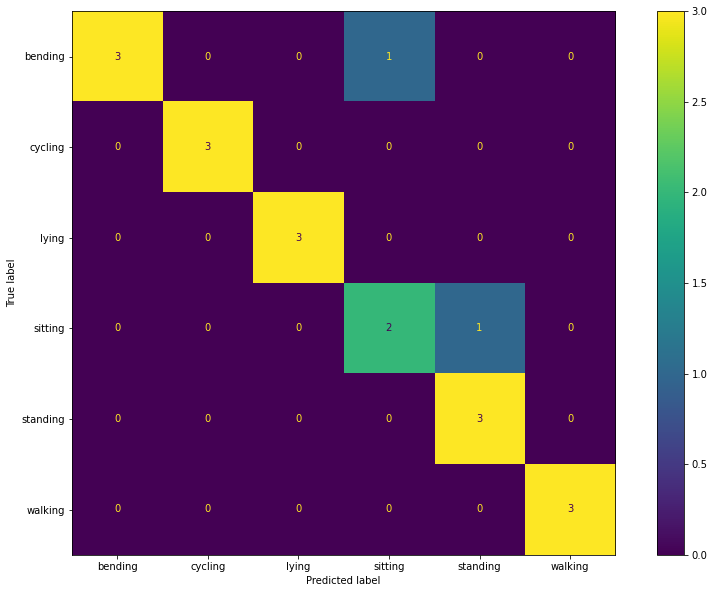

Weighted AUC score using One vs. Rest scoring: 0.9668859649122807
accuracy: 0.8947368421052632
Average f1 score:  0.8968253968253967
Average recall:    0.9027777777777777
Average precision: 0.9027777777777777


In [165]:
X = new_feature_dfs[16].drop('activity', axis=1)
y = new_feature_dfs[16]['activity']
from sklearn.metrics import roc_auc_score
scaler = preprocessing.StandardScaler().fit(X)
scaled_X = scaler.transform(X)

clf = LogisticRegression(random_state=69, max_iter=1000, multi_class="multinomial").fit(scaled_X, y)

predictions = clf.predict(scaler.transform(X_test))
y_prob = clf.predict_proba(scaler.transform(X_test))
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)

from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1_score = f1_score(y_test, predictions, average='macro')

print(f'Weighted AUC score using One vs. Rest scoring: {weighted_roc_auc_ovr}')
print(f'accuracy: {clf.score(scaler.transform(X_test), y_test)}')
print(f'Average f1 score:  {f1_score}\nAverage recall:    {recall}\nAverage precision: {precision}')

In [164]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X, y)

clf.score(X_test, y_test)

0.8947368421052632